## Recreating Analysis of Piao Nature 2008

### Step 5: get tmp-co2 correlations and trends in ccgcrv outputs

In [3]:
import pandas as pd
from piao2008_get_ccgcrv import get_ccgcrv
from piao2008_get_tmp_mean import get_tmp_mean
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Prepare variables
co2_file = '../data/piao_2008/piao_co2_fm.csv'
stations_file = '../data/piao_2008/piao_stations.csv'
stations = pd.read_csv(stations_file)
calc_tmps = False

In [5]:
# Get ccgcrv output
ccg_output, ccgmeans = get_ccgcrv(co2_file=co2_file, stations_file=stations_file, start_col='start_total', end_col='end_total')

In [6]:
def get_station_tmp_mean(station):
    # Get temperature data
    S = int(stations.loc[stations['name']==station, 'lat']) - 20
    N = np.min([int(stations.loc[stations['name']==station, 'lat']) + 20, 90])
    tmp_mean = get_tmp_mean(tmp_file='/Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmp.dat.nc',
        limS=S,
        limN=N)
    file_out = 'tmp_yearly_means_' + station + '.csv'
    tmp_mean.to_csv('../data/piao_2008/' + file_out)

In [7]:
if calc_tmps:
    for s in stations['name']:
        get_station_tmp_mean(s)

In [29]:
# Function to make Piao Figure 1a

def make_piaofig1a(station, start_col, end_col, name=''):

    # Prepare the data and calculate anomalies ----

    tmp_file = 'tmp_yearly_means_' + station + '.csv'

    tmp_mean = pd.read_csv('../data/piao_2008/' + tmp_file, index_col='year')

    # Select time period for temperature data
    year_beg = int(stations.loc[stations['name']==station, start_col])
    year_end = int(stations.loc[stations['name']==station, end_col])
    years = np.arange(year_beg, year_end+1)

    # Calculate anomalies
    tmp = tmp_mean.loc[year_beg:year_end,'tmp_SON']
    tmp_ano = tmp - tmp.mean()

    ccg_y = ccg_output[station]['yearly']
    azc = ccg_y['tcu_doy'].loc[ccg_y['year'].between(year_beg, year_end)]
    azc.loc[azc < 150] = azc.loc[azc < 150] + 365

    azc_ano = azc - azc.mean()


    # Plot AZC and tmp anomalies time series ----

    plt.rcParams['figure.figsize'] = [8, 5]

    fig,ax=plt.subplots()
    ax.plot(years, azc_ano, '--', color='red', label='AZC anomaly')
    ax.set_ylabel("Autumn zero crossing anomaly (days)", color="red")
    # ax.set_ylim([-15, 15])
    ax2=ax.twinx()
    ax2.plot(years, tmp_ano, '--', color='black', label='Autumn temperature anomaly', linewidth=2)
    ax2.set_ylabel("Autumn temperature anomaly (ºC)")
    # ax2.set_ylim([-2, 2])
    ax2.invert_yaxis()
    plt.title(station)
    plt.show()

    # Save the plot
    fig.savefig('../plots/' + name + '_' + station + '_azc-tmp.jpg',
                format='jpeg',
                dpi=100,
                bbox_inches='tight')


    # Plot correlations and get r value -----

    # Function to calculate and plot regression statistics
    def plot_linreg(x_in, y_in, col='grey', fmt='o', lab = '', alpha=0.7):
        from sklearn.linear_model import LinearRegression
        from scipy import stats
        
        # Use scipy to get stats
        r, p = stats.pearsonr(x_in, y_in)
        # t, p = stats.kendalltau(x_in, y_in)[0] # used for ordinal data

        # Use sklearn to get predicted regression values
        model = LinearRegression()  
        x = x_in.values.reshape(-1, 1) # sklearn fit requires a two dimensional array
        y = y_in.values.reshape(-1, 1)
        model.fit(x, y)
        y_pred = model.predict(x)
        # r = np.sqrt(model.score(x, y))
        

        r_val = "r = {:.3f}".format(r)
        p_val = "; p = {:.3f}".format(p)
        plt.plot(x, y, fmt, color=col, alpha=alpha,label=lab+'\n'+r_val+p_val)
        plt.plot(x, y_pred, '--', color=col)

    plt.rcParams['figure.figsize'] = [5, 5]
    xy = pd.DataFrame({'x': tmp_ano.to_numpy(), 'y': azc_ano.to_numpy()})
    xy = xy.sort_values(by='x')
    plot_linreg(xy['x'], xy['y'], fmt='o', col='grey', lab='Temp anomaly vs AZC anomaly', alpha=1)
    plt.title(label=s)
    plt.legend(loc='upper left')
    plt.show()
    
    

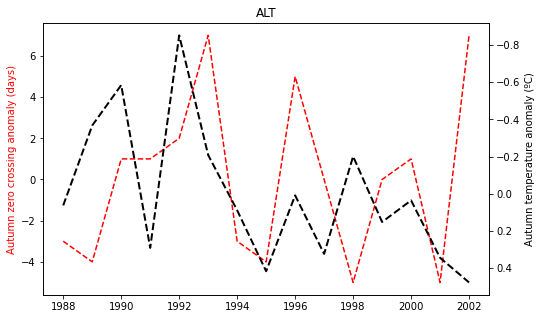

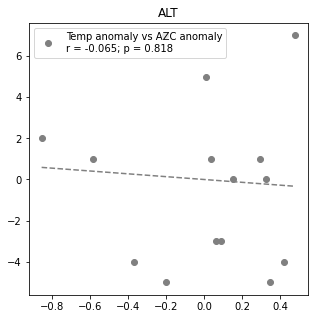

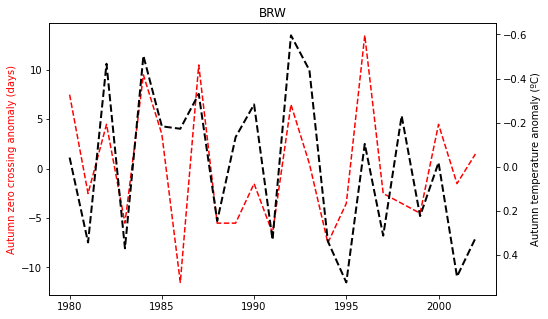

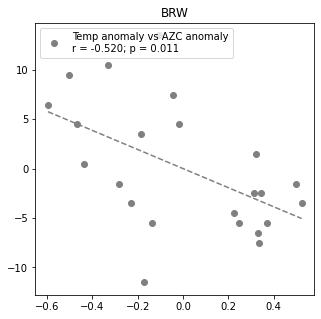

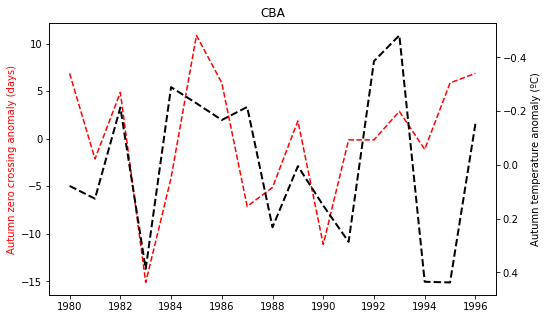

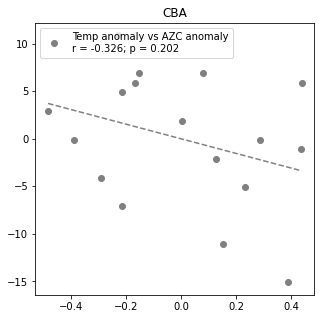

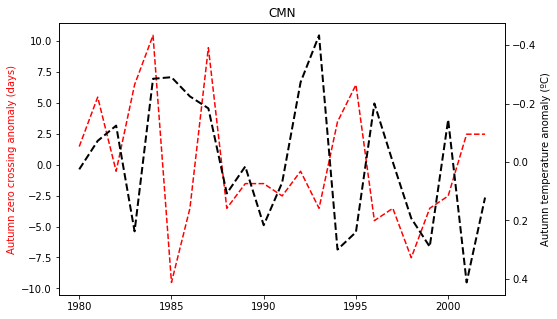

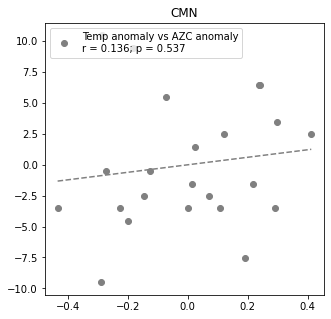

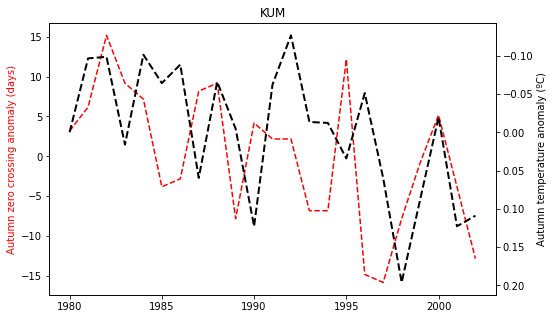

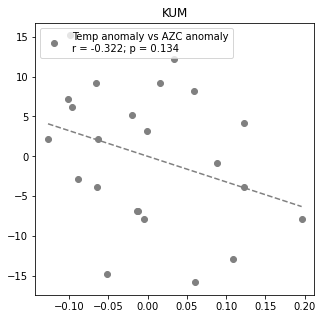

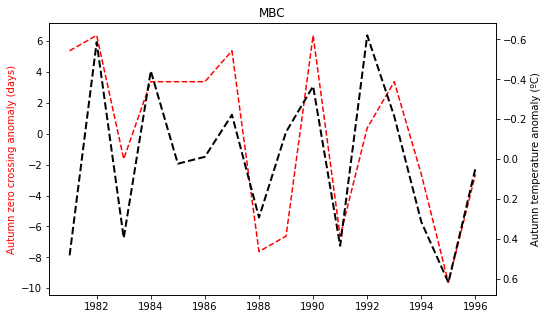

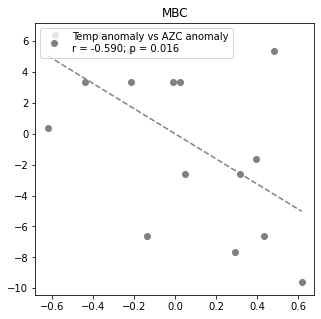

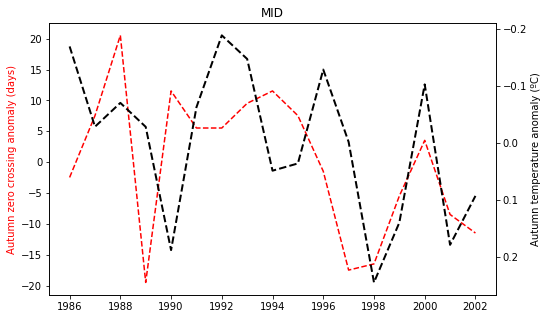

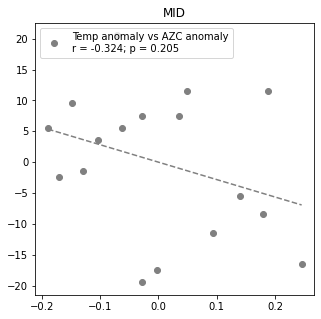

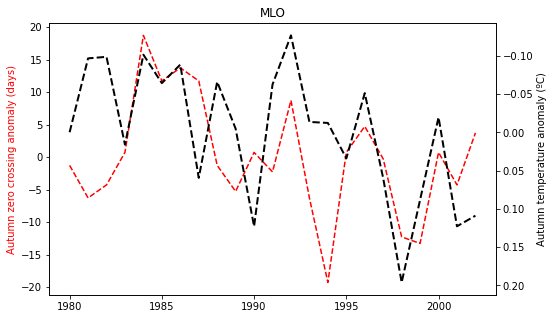

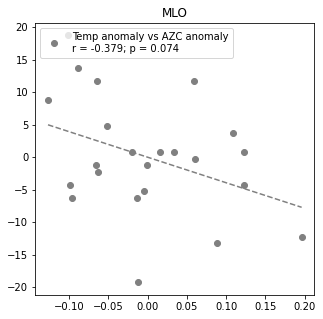

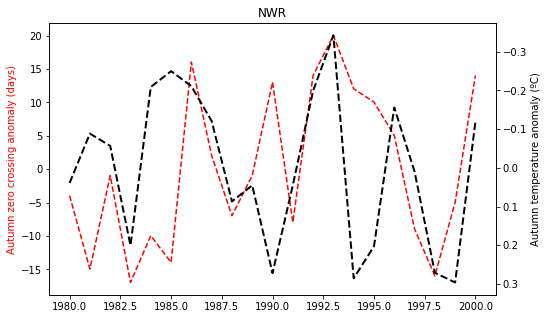

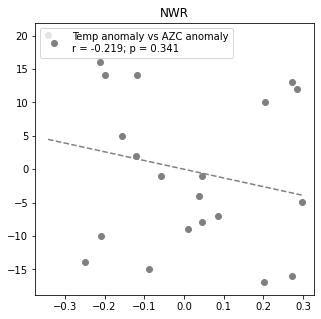

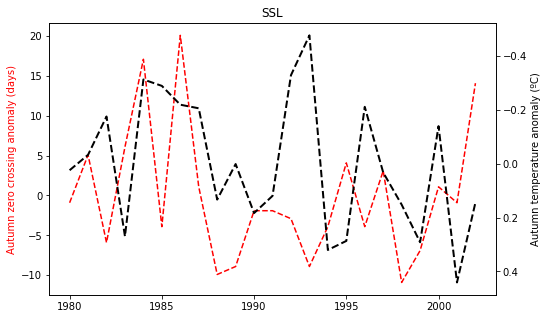

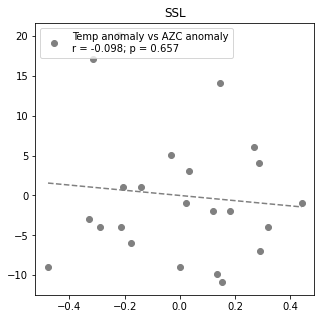

In [30]:
# Get results to reproduce Piao 2008 Figure 1a
start_col = 'start_piao2008'
end_col = 'end_piao2008'
name = "piao"
for s in stations['name']:
    make_piaofig1a(station=s, start_col=start_col, end_col=end_col, name=name)

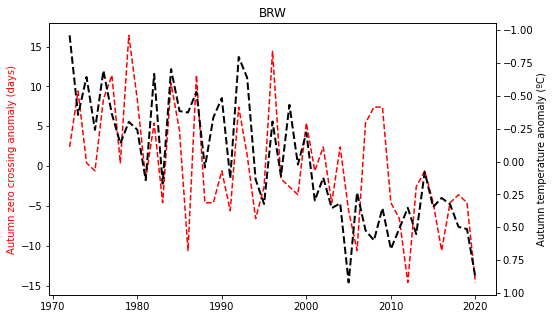

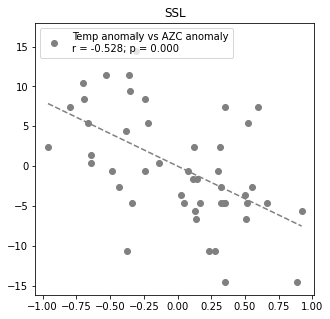

In [34]:
#  Test specific cases
start_col = 'start_total'
end_col = 'end_total'
name = "total"
make_piaofig1a(station="BRW", start_col=start_col, end_col=end_col, name=name)